# Scipy - Development of cumulative_simpson function
*March 16th 2023*

**Aim**
 - Implement function for cumulative integration of samples (at even or uneven intervals), similar to scipy.integrate.cumulative_trapezoid
 - Benchmark function against scipy.integrate.cumulative_trapezoid and scipy.integrate.simpson

**Purpose**

The cumulative integration and differentiation of numerical samples is a common operation in the engineering domain. Differentiation is possible the numpy.gradient function. However, there is no accurate out-of-the-box function for cumulative integration. The scipy library only provides the scipy.integrate.cumulative_trapezoid function, but this is insufficiently accurate for engineering purposes.

CAE softwares such as LS-DYNA provide simpson's integration as a default processing option. Adding this to Scipy.integrate will improve adoption in the engineering domains.

## Import Dependencies

In [25]:
# Standard library imports
import os
import sys
from itertools import product, accumulate
from time import perf_counter
from typing import Optional

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid, simpson
from scipy.interpolate import interp1d
from sympy import symbols, solve, collect, simplify, integrate, Eq, Integral, expand, factor, apart, cancel

np.random.seed = 42

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Derive Simpson's 1/3 rule for equal intervals

Simpson's 1/3 rule assumes a quadratic function between 3 equally spaced points.
- I.e. consider 3 consecutive points, $(x_1, y_1)$, $(x_2, y_2)$, $(x_3, y_3)$.
- $x_2 - x_1 = h_1= h$, $x_3 - x_2 = h_2 = h$
- Using the fact that the points are equally-spaced, the points become: $(0, y_1)$, $(h, y_2)$, $(2h, y_3)$.
- The 1/3 rule is derived by assuming the function: $y = Ax^2 + Bx + C$.
- $A$, $B$, $C$ can be calculated by solving the 3 simultaneous equations obtained from substituting the 3 points into the quadratic function.
- The integral of the function can then be calculated from $x_1$ to $x_2$, $x_2$ to $x_3$, or $x_1$ to $x_3$. The integral will be in terms of $h$, $y_1$, $y_2$, and $y_3$.

The derived integral equations can be used in the numerical integration schemes.

In [26]:
from sympy.abc import A, B, C, D, x, y

h, x1, x2, x3, x4, y1, y2, y3, y4 = symbols("h, x1, x2, x3, x4, y1, y2, y3, y4")

In [27]:
# Simultaneous equations for Simpsons 1/3 rule
poly_eqns = [
    A*0**2 + B*0 + C - y1,
    A*h**2 + B*h + C - y2,
    A*(2*h)**2 + B*(2*h) + C - y3,
]
poly_res = solve(poly_eqns, (A, B, C), dict=True)[0]

print("Simpson's 1/3 rule solutions")
for key, value in poly_res.items():
    display(Eq(key, value))

Simpson's 1/3 rule solutions


Eq(A, (y1 - 2*y2 + y3)/(2*h**2))

Eq(B, (-3*y1 + 4*y2 - y3)/(2*h))

Eq(C, y1)

<a id="Equal_interval_equations"></a>

**Equations to calculate Simpson's 1/3 rule integrals using equal intervals**

In [28]:
int1 = integrate(poly_res[A]*x**2 + poly_res[B]*x + poly_res[C], (x, 0, 2*h))
int2 = integrate(poly_res[A]*x**2 + poly_res[B]*x + poly_res[C], (x, 0, h))
int3 = integrate(poly_res[A]*x**2 + poly_res[B]*x + poly_res[C], (x, h, 2*h))

print("\nEquation 1")
display(Eq(Integral(y, (x, 0, 2*h)), collect(int1, h)))

print("\nEquation 2")
display(Eq(Integral(y, (x, 0, h)), collect(int2, h)))

print("\nEquation 3")
display(Eq(Integral(y, (x, h, 2*h)), collect(int3, h)))


Equation 1


Eq(Integral(y, (x, 0, 2*h)), h*(y1/3 + 4*y2/3 + y3/3))


Equation 2


Eq(Integral(y, (x, 0, h)), h*(5*y1/12 + 2*y2/3 - y3/12))


Equation 3


Eq(Integral(y, (x, h, 2*h)), h*(-y1/12 + 2*y2/3 + 5*y3/12))

As confirmation, equation 1 matches with the derived formula in https://en.wikipedia.org/wiki/Simpson%27s_rule#Quadratic_interpolation.

## Define Function to use Simpson's 1/3 rule for cumulative integration with equal intervals

To convert the above integrals into a cumulative integration function algorithm, we will consider the 1d example plotted below.

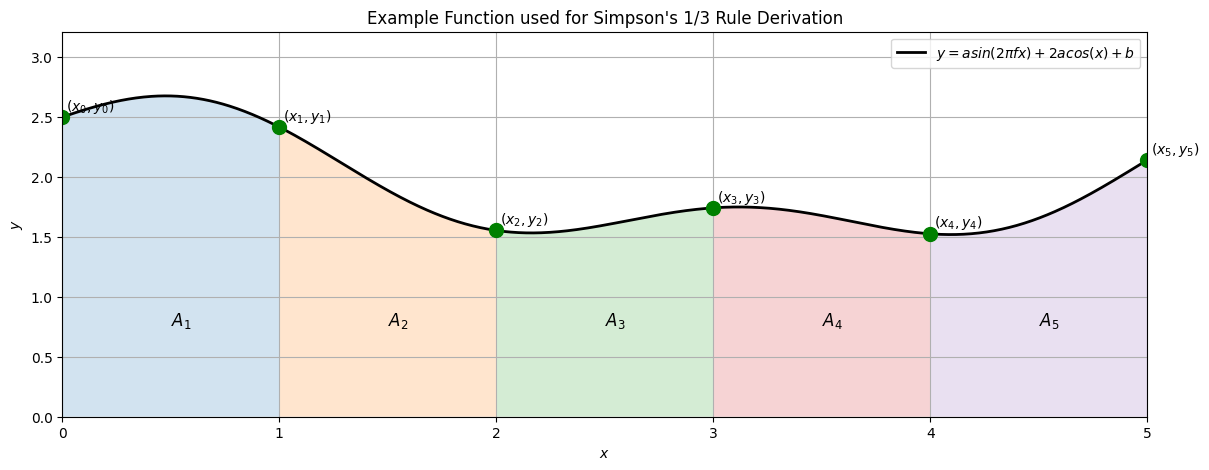

In [29]:
f = 0.4
a = 0.25
b = 2
max_x = 5

def y_func(x: np.ndarray) -> np.ndarray:
    return a*np.sin(f*2*np.pi*x) + b + 2*a * np.cos(x)

# Define figure and plot main function to be integrated
fig, ax = plt.subplots(figsize=(14, 5))
x = np.linspace(0, max_x, 1000)
y = y_func(x)
ax.plot(x, y, 'k', linewidth=2, label=r"$y=a sin(2 \pi fx) + 2 a cos(x) + b$")
ax.set_ylim(0, max(y)*1.2)
ax.set_xlim(min(x), max(x))
ax.grid()

# Fill areas
for i in range(0, max_x):
    x_sample = np.linspace(i, i+1, 1000)
    ax.fill_between(x_sample, y_func(x_sample), alpha=0.2)

# Plot points
x_pts = np.arange(max_x+1)
y_pts = y_func(x_pts)
ax.plot(x_pts, y_pts, "go", markersize=10)

# Labeling and annotation
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Example Function used for Simpson's 1/3 Rule Derivation")
ax.legend(loc="upper right")

for i, xy in enumerate(zip(x_pts, y_pts)):
    ax.annotate(f"$(x_{i}, y_{i})$", xy=xy, xytext=(3, 5), textcoords="offset points")

for i in range(max_x):
    x_A = 1/2 * (x_pts[i] + x_pts[i+1])
    ax.text(x_A, min(y)/2, f"$A_{i+1}$", fontsize=12)

Consider the integral of the function shown in the above graph:

$y=a sin(2 \pi fx) + 2 a cos(x) + b$

where, a, f, and b are constants.

Assume that the function has been sampled at equal intervals of h = 1. This gives the points $(x_i, y_i)$.

Using the sampled points, we will estimate the cumulative integral of y from x=0 to x=5:

$\int_0^5{(a sin(2 \pi fx) + 2 a cos(x) + b) dx}$

The integral of y can be visualised as the cumulative sum of the Areas, $A_i$. To obtain the cumulative integral, we will first estimate the areas using the quadratic interpolations from Simpson's 1/3 rule.

### Area of $A_1$

$A_1 = \int_0^1{y dx}$

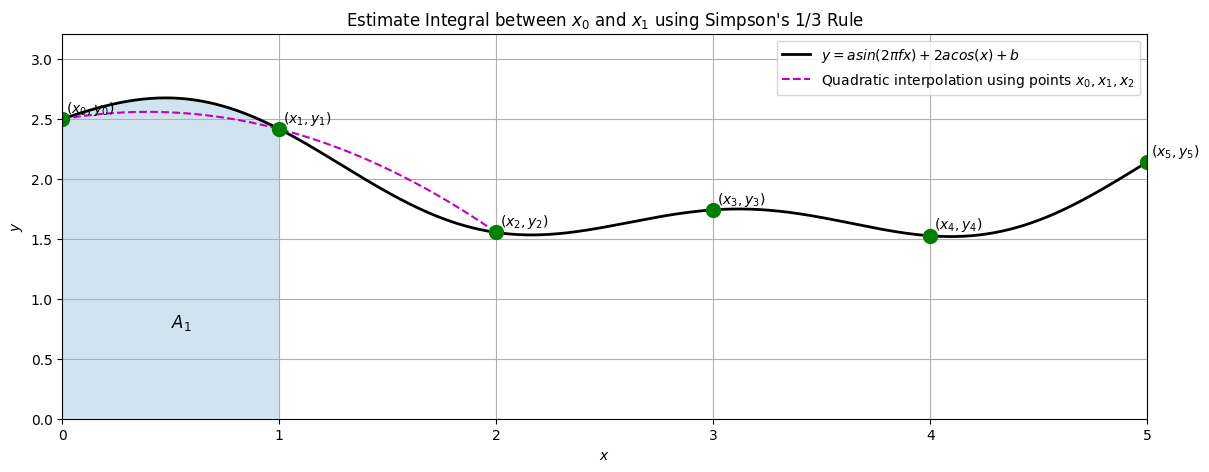

In [30]:
# Define figure and plot main function to be integrated
fig, ax = plt.subplots(figsize=(14, 5))
x = np.linspace(0, max_x, 1000)
y = y_func(x)
ax.plot(x, y, 'k', linewidth=2, label=r"$y=a sin(2 \pi fx) + 2 a cos(x) + b$")
ax.set_ylim(0, max(y)*1.2)
ax.set_xlim(min(x), max(x))
ax.grid()

# Fill areas
i = 0
x_sample = np.linspace(i, i+1, 1000)
ax.fill_between(x_sample, y_func(x_sample), alpha=0.2)

# Define points
x_pts = np.arange(max_x+1)
y_pts = y_func(x_pts)

# Plot assumed quadratic functions
x_sample = x_pts[i:i+3]
temp_x = np.linspace(min(x_sample), max(x_sample), num=100)
func = interp1d(x_sample, y_func(x_sample), kind="quadratic", fill_value="extrapolate")
ax.plot(temp_x, func(temp_x), "m--", label="Quadratic interpolation using points $x_0, x_1, x_2$")

# Plot points
ax.plot(x_pts, y_pts, "go", markersize=10)

# Labeling and annotation
x_A = 1/2 * (x_pts[i] + x_pts[i+1])
ax.text(x_A, min(y)/2, f"$A_{i+1}$", fontsize=12)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Estimate Integral between $x_0$ and $x_1$ using Simpson's 1/3 Rule")
ax.legend(loc="upper right")

for i, xy in enumerate(zip(x_pts, y_pts)):
    ax.annotate(f"$(x_{i}, y_{i})$", xy=xy, xytext=(3, 5), textcoords="offset points")

The area of $A_1$ can be calculated using the quadratic interpolation over points $(x_0, y_0), (x_1, y_1)$, and $(x_2, y_2)$, using [equation 2](#Equal_interval_equations):

$\int_0^h{y dx} = h(\frac{5y_0}{12} + \frac{2y_1}{3} - \frac{y_2}{12})$

$A_1 = \int_0^1{y dx} = h(\frac{5y_0}{12} + \frac{2y_1}{3} - \frac{y_2}{12})$

$h = 1$, the spacing between points $x_i$ in this example.


### Areas of $A_2, A_3, A_4$

$A_2 = \int_1^2{y dx}$

$A_3 = \int_2^3{y dx}$

$A_4 = \int_3^4{y dx}$

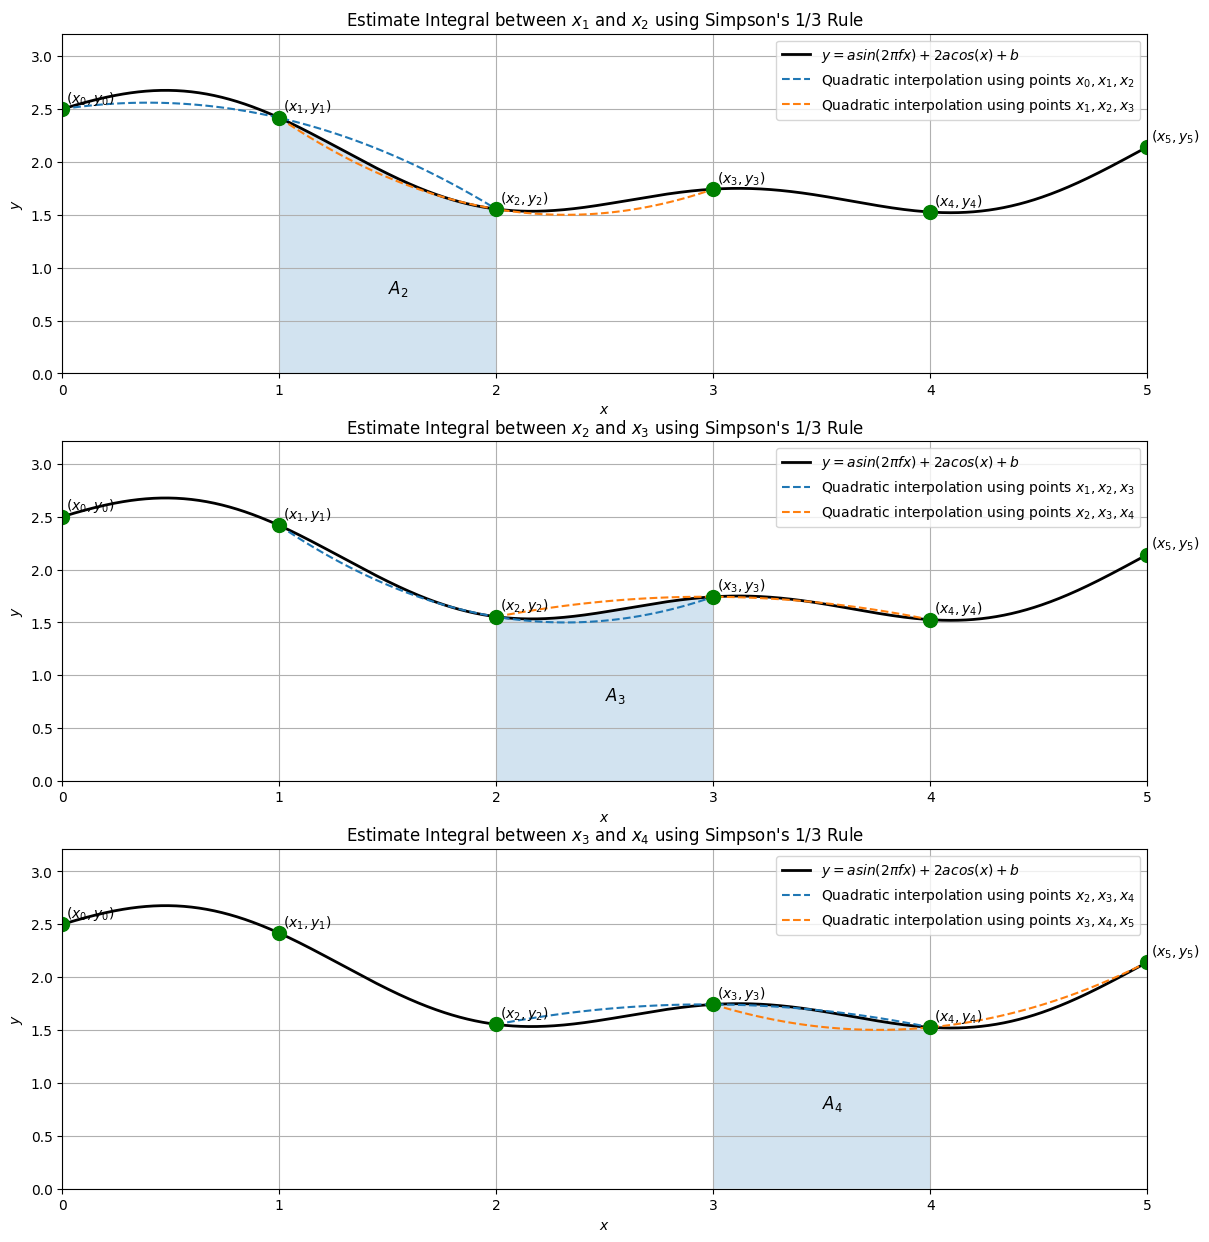

In [31]:
# Define figure and plot main function to be integrated
fig, axes = plt.subplots(nrows=3, figsize=(14, 15))
for j, ax in enumerate(axes):
    x = np.linspace(0, max_x, 1000)
    y = y_func(x)
    ax.plot(x, y, 'k', linewidth=2, label=r"$y=a sin(2 \pi fx) + 2 a cos(x) + b$")
    ax.set_ylim(0, max(y)*1.2)
    ax.set_xlim(min(x), max(x))
    ax.grid()

    # Fill areas
    i = j + 1
    x_sample = np.linspace(i, i+1, 1000)
    ax.fill_between(x_sample, y_func(x_sample), alpha=0.2)

    # Define points
    x_pts = np.arange(max_x+1)
    y_pts = y_func(x_pts)

    # Plot assumed quadratic functions
    for k in range(j, j+2):
        x_sample = x_pts[k:k+3]
        temp_x = np.linspace(min(x_sample), max(x_sample), num=100)
        func = interp1d(x_sample, y_func(x_sample), kind="quadratic", fill_value="extrapolate")
        ax.plot(temp_x, func(temp_x), "--", label=f"Quadratic interpolation using points $x_{k}, x_{k+1}, x_{k+2}$")

    # Plot points
    ax.plot(x_pts, y_pts, "go", markersize=10)

    # Labeling and annotation
    x_A = 1/2 * (x_pts[i] + x_pts[i+1])
    ax.text(x_A, min(y)/2, f"$A_{i+1}$", fontsize=12)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_title(f"Estimate Integral between $x_{i}$ and $x_{i+1}$ using Simpson's 1/3 Rule")
    ax.legend(loc="upper right")

    for i, xy in enumerate(zip(x_pts, y_pts)):
        ax.annotate(f"$(x_{i}, y_{i})$", xy=xy, xytext=(3, 5), textcoords="offset points")


The area of $A_2$ can be calculated in two ways:
1. Using the quadratic interpolation over points $(x_0, y_0), (x_1, y_1)$, and $(x_2, y_2)$, with [equation 3](#Equal_interval_equations).
    - $A_{2_1} = \int_1^2{y dx} = h(-\frac{y_1}{12} + \frac{2y_2}{3} + \frac{5y_3}{12})$
2. Using the quadratic interpolation over points $(x_1, y_1)$, $(x_2, y_2)$, and $(x_3, y_3)$, with [equation 2](#Equal_interval_equations).
    - $A_{2_2} = \int_1^2{y dx} = h(\frac{5y_1}{12} + \frac{2y_2}{3} - \frac{y_3}{12})$

$A_2$ will be estimated by taking the mean of the two values:

$A_2 = \frac{1}{2} (A_{2_1} + A_{2_2})$

Areas $A_3$ and $A_4$ can similarly be estimated from two separate quadratic interpolations. The areas are similarly calculated by taking the mean from each interpolation.


### Area of $A_5$

$A_5 = \int_4^5{y dx}$

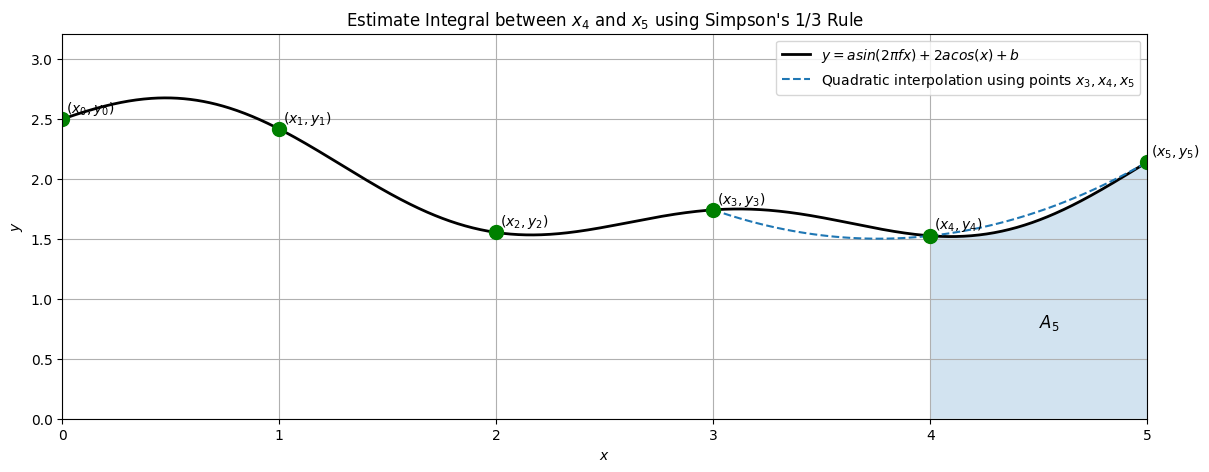

In [32]:
# Define figure and plot main function to be integrated
fig, ax = plt.subplots(figsize=(14, 5))
x = np.linspace(0, max_x, 1000)
y = y_func(x)
ax.plot(x, y, 'k', linewidth=2, label=r"$y=a sin(2 \pi fx) + 2 a cos(x) + b$")
ax.set_ylim(0, max(y)*1.2)
ax.set_xlim(min(x), max(x))
ax.grid()

# Fill areas
i = 4
x_sample = np.linspace(i, i+1, 1000)
ax.fill_between(x_sample, y_func(x_sample), alpha=0.2)

x_A = 1/2 * (x_pts[i] + x_pts[i+1])
ax.text(x_A, min(y)/2, f"$A_{i+1}$", fontsize=12)

# Define points
x_pts = np.arange(max_x+1)
y_pts = y_func(x_pts)

# Plot assumed quadratic functions
x_sample = x_pts[i-1:i+2]
temp_x = np.linspace(min(x_sample), max(x_sample), num=100)
func = interp1d(x_sample, y_func(x_sample), kind="quadratic", fill_value="extrapolate")
ax.plot(temp_x, func(temp_x), "--", label=f"Quadratic interpolation using points $x_{i-1}, x_{i}, x_{i+1}$")

# Plot points
ax.plot(x_pts, y_pts, "go", markersize=10)

# Labeling and annotation
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title(f"Estimate Integral between $x_{i}$ and $x_{i+1}$ using Simpson's 1/3 Rule")
ax.legend(loc="upper right")

for i, xy in enumerate(zip(x_pts, y_pts)):
    ax.annotate(f"$(x_{i}, y_{i})$", xy=xy, xytext=(3, 5), textcoords="offset points")


The area of $A_5$ can be only be calculated using the quadratic interpolation over points $(x_3, y_3), (x_4, y_4)$, and $(x_5, y_5)$, using [equation 3](#Equal_interval_equations):

$A_5 = \int_4^5{y dx} = h(-\frac{y_3}{12} + \frac{2y_4}{3} + \frac{5y_5}{12})$

After calculating all the areas, $A_i$ using the quadratic interpolations, the cumulative integration can be calculated by taking the cumulative sum of the areas.

This logic is written as a function:

In [33]:
def cumulative_simpson_equal(
    y: np.ndarray, x: Optional[np.ndarray] = None, dx: float = 1, initial: Optional[float] = 0,
) -> np.ndarray:
    """Simpson's 1/3 rule with equal intervals. 
    Assumes x consists of equally spaced points and has at least 3 points."""
    y = np.asarray(y)

    if x is not None:
        dx = (x[-1] - x[0])/(len(x) - 1)
    
    # Equation 2: Calculate sub-integrals (areas) for all but last area
    sub_integrals_h1 = dx/3 * (5*y[:-2]/4 + 2*y[1:-1] - y[2:]/4)

    # Equation 3: Calculate sub-integrals (areas) for all but first area
    sub_integrals_h2 = dx/3 * (-y[:-2]/4 + 2*y[1:-1] + 5*y[2:]/4)

    if len(y) == 3:
        sub_integrals = np.concatenate((
            [sub_integrals_h1[0]],
            [sub_integrals_h2[-1]],
        ))
    else:
        sub_integrals = np.concatenate((
            [sub_integrals_h1[0]],
            (sub_integrals_h1[1:] + sub_integrals_h2[:-1])/2,
            [sub_integrals_h2[-1]],
        ))
    
    integral = np.cumsum(sub_integrals)

    if initial is not None:
        initial = np.ones(len(y)) * initial
        initial[1:] += integral
        result = initial
    else:
        result = integral
    
    return result

## Derive Simpson's 1/3 rule for unequal intervals

Simpson's 1/3 rule can also be derived for samples with unequally spaced points.
- I.e. consider 3 consecutive points, $(p_1, q_1)$, $(p_2, q_2)$, $(p_3, q_3)$.
- $p_2 - p_1 = h_1$, $p_3 - p_2 = h_2$
- Using the intervals, the points become: $(0, q_1)$, $(h_1, q_2)$, $(h_1+h_2, q_3)$.
- The 1/3 rule is derived by assuming the function: $q = \alpha p^2 + \beta p + \gamma$.
- $\alpha$, $\beta$, $\gamma$ can be calculated by solving the 3 simultaneous equations obtained from substituting the 3 points into the quadratic function.
- The integral of the function can then be calculated from $p_1$ to $p_2$, $p_2$ to $p_3$, or $p_1$ to $p_3$. The integral will be in terms of $h_1$, $h_2$, $q_1$, $q_2$, and $q_3$.

In [34]:
from sympy.abc import p, q

h1, h2, alpha, beta, gamma, q1, q2, q3 = symbols("h1, h2, alpha, beta, gamma, q1, q2, q3")

In [35]:
# Simultaneous equations for Simpsons 1/3 rule with uneven intervals
poly_uneven_eqns = [
    alpha*0**2 + beta*0 + gamma - q1,
    alpha*h1**2 + beta*h1 + gamma - q2,
    alpha*(h1+h2)**2 + beta*(h1+h2) + gamma - q3,
]

In [36]:
poly_uneven_res = solve(poly_uneven_eqns, (alpha, beta, gamma), dict=True)[0]

In [37]:
print("Simpson's 1/3 rule solutions with uneven intervals")
for key, value in poly_uneven_res.items():
    display(Eq(key, value))

Simpson's 1/3 rule solutions with uneven intervals


Eq(alpha, (-h1*q2 + h1*q3 + h2*q1 - h2*q2)/(h1**2*h2 + h1*h2**2))

Eq(beta, (h1**2*q2 - h1**2*q3 - 2*h1*h2*q1 + 2*h1*h2*q2 - h2**2*q1 + h2**2*q2)/(h1**2*h2 + h1*h2**2))

Eq(gamma, q1)

<a id="Unequal_interval_equations"></a>

**Equations to calculate Simpson's 1/3 rule integrals using unequal intervals**

In [38]:
int1 = integrate(poly_uneven_res[alpha]*p**2 + poly_uneven_res[beta]*p + poly_uneven_res[gamma], (p, 0, h1+h2))
int2 = integrate(poly_uneven_res[alpha]*p**2 + poly_uneven_res[beta]*p + poly_uneven_res[gamma], (p, 0, h1))
int3 = integrate(poly_uneven_res[alpha]*p**2 + poly_uneven_res[beta]*p + poly_uneven_res[gamma], (p, h1, h1+h2))

def simplify_integral_expr(expr):
    collected_terms = {
        symbol: factor(expand(expr).coeff(symbol))
        for symbol in (q1, q2, q3)
    }
    new_expr = None
    for symbol in q1, q2, q3:
        if new_expr is None:
            new_expr = collected_terms[symbol]*symbol
        else:
            new_expr += collected_terms[symbol]*symbol
    return new_expr

simple_int1 = simplify_integral_expr(int1)
simple_int2 = simplify_integral_expr(int2)
simple_int3 = simplify_integral_expr(int3)

print("\nEquation 1")
display(Eq(Integral(q, (p, 0, h1+h2)), simple_int1))
print("\nEquation 2")
display(Eq(Integral(q, (p, 0, h1)), simple_int2))
print("\nEquation 3")
display(Eq(Integral(q, (p, h1, h1+h2)), simple_int3))


Equation 1


Eq(Integral(q, (p, 0, h1 + h2)), -q3*(h1 - 2*h2)*(h1 + h2)/(6*h2) + q1*(h1 + h2)*(2*h1 - h2)/(6*h1) + q2*(h1 + h2)**3/(6*h1*h2))


Equation 2


Eq(Integral(q, (p, 0, h1)), -h1**3*q3/(6*h2*(h1 + h2)) + h1*q1*(2*h1 + 3*h2)/(6*(h1 + h2)) + h1*q2*(h1 + 3*h2)/(6*h2))


Equation 3


Eq(Integral(q, (p, h1, h1 + h2)), h2*q3*(3*h1 + 2*h2)/(6*(h1 + h2)) - h2**3*q1/(6*h1*(h1 + h2)) + h2*q2*(3*h1 + h2)/(6*h1))

#### Verify derviation by substituting $h_2 = h_1$, and ensuring the previous solution for [equal intervals](#Equal_interval_equations) is obtained

In [39]:
for i, expr in enumerate((simple_int1, simple_int2, simple_int3)):
    print(f"Equation {i + 1}")
    display(simplify(expr.subs(h2, h1)))

Equation 1


h1*(q1 + 4*q2 + q3)/3

Equation 2


h1*(5*q1 + 8*q2 - q3)/12

Equation 3


h1*(-q1 + 8*q2 + 5*q3)/12

The equations match with what was derived earlier for the special case of equal intervals.

## Define Function to use Simpson's 1/3 rule for cumulative integration with unequal intervals

The function for unequal intervals is defined with the same logic as that for equal intervals, but with the updated integral formulae.

In [40]:
def cumulative_simpson_unequal(
    y: np.ndarray, x: Optional[np.ndarray] = None, dx: float = 1, 
    initial: Optional[float] = 0,
) -> np.ndarray:
    """Simpson's 1/3 rule with unequal intervals. 
    Assumes x has at least 3 points."""
    y = np.asarray(y)
    if x is not None:
        x = np.asarray(x)
    else:
        x = np.arange(0, dx*len(y), dx)

    d = np.diff(x)
    h1 = d[:-1]
    h2 = d[1:]
    y1 = y[:-2]
    y2 = y[1:-1]
    y3 = y[2:]
    
    # Equation 2: Calculate sub-integrals (areas) for all but last area
    sub_integrals_h1 = y1*(2*h1 + 3*h2)/(h1 + h2)*h1/6 + y2*(h1 + 3*h2)*h1/(6*h2) - y3*(h1**3/(6*h2))/(h1 + h2)

    # Equation 3: Calculate sub-integrals (areas) for all but first area
    sub_integrals_h2 = -y1*(h2**3/(6*h1))/(h1 + h2) + y2*(3*h1 + h2)*h2/(6*h1) + y3*(3*h1 + 2*h2)/(h1 + h2)*h2/6

    if len(y) == 3:
        sub_integrals = np.concatenate((
            [sub_integrals_h1[0]],
            [sub_integrals_h2[-1]],
        ))
    else:
        sub_integrals = np.concatenate((
            [sub_integrals_h1[0]],
            (sub_integrals_h1[1:] + sub_integrals_h2[:-1])/2,
            [sub_integrals_h2[-1]],
        ))
    
    integral = np.cumsum(sub_integrals)

    if initial is not None:
        initial = np.ones(len(y)) * initial
        initial[1:] += integral
        result = initial
    else:
        result = integral

    return result


def scipy_simps(    
    y: np.ndarray, x: Optional[np.ndarray] = None, dx: float = 1, 
    initial: Optional[float] = 0,
) -> np.ndarray:
    """Scipy Simpsons 1/3 rule implementation"""
    
    y = np.asarray(y)    
    if x is not None:
        x = np.asarray(x)
    else:
        x = np.arange(0, dx*len(y), dx)
    
    integral = np.array([simpson(y[:i], x[:i]) for i in range(2, len(y)+1)])

    if initial is not None:
        initial = np.ones(len(y)) * initial
        initial[1:] += integral
        result = initial
    else:
        result = integral

    return result

## Validate Integration Functions by Comparing to Theoretical Examples

Example functions used:
- $y=a sin(2 \pi fx) + 2 a cos(x) + b$, where a, f, and b are constants
- $y= sin(\alpha x)$, where $\alpha$ is a constant

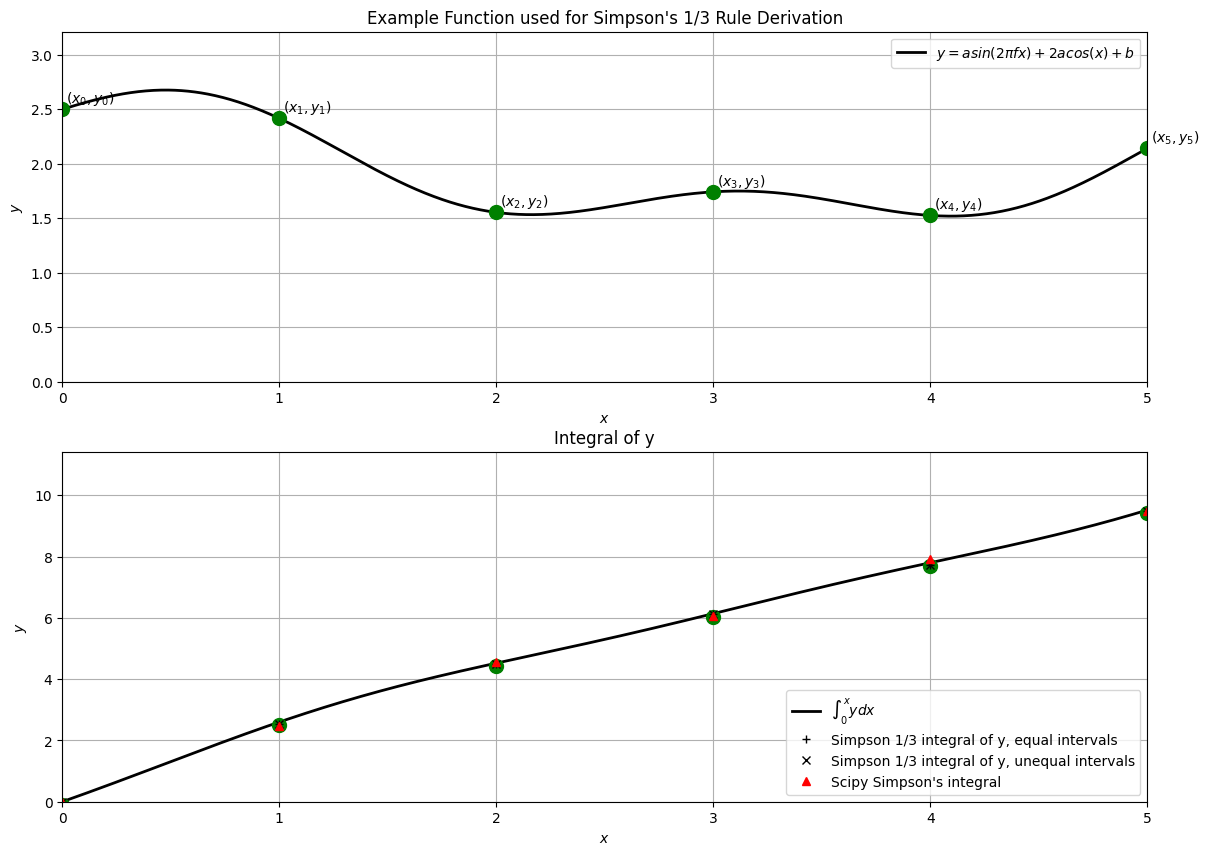

In [41]:
f = 0.4
a = 0.25
b = 2
max_x = 5

def y_func(x: np.ndarray) -> np.ndarray:
    return a*np.sin(f*2*np.pi*x) + b + 2*a * np.cos(x)

def int_y_func(x: np.ndarray) -> np.ndarray:
    return -a*np.cos(f*2*np.pi*x)/(2*np.pi*f) + 2*a * np.sin(x) + b*x

# Define figure and plot main function to be integrated
fig, axes = plt.subplots(nrows=2, figsize=(14, 10))
ax = axes[0]
x = np.linspace(0, max_x, 1000)
y = y_func(x)
ax.plot(x, y, 'k', linewidth=2, label=r"$y=a sin(2 \pi fx) + 2 a cos(x) + b$")
ax.set_ylim(0, max(y)*1.2)
ax.set_xlim(min(x), max(x))
ax.grid()

# Plot points
x_pts = np.arange(max_x+1)
y_pts = y_func(x_pts)
ax.plot(x_pts, y_pts, "go", markersize=10)

# Labeling and annotation
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Example Function used for Simpson's 1/3 Rule Derivation")
ax.legend(loc="upper right")

for i, xy in enumerate(zip(x_pts, y_pts)):
    ax.annotate(f"$(x_{i}, y_{i})$", xy=xy, xytext=(3, 5), textcoords="offset points")

ax = axes[1]
int_x = np.linspace(0, max_x, 1000)
int_y = int_y_func(x) - int_y_func(0)
ax.plot(int_x, int_y, 'k', linewidth=2, label=r"$\int_0^x{y dx}$")
ax.set_ylim(0, max(int_y)*1.2)
ax.set_xlim(min(int_x), max(int_x))
ax.grid()

int_y_pts = int_y_func(x_pts)
simps_3_int_y = cumulative_simpson_equal(y_pts, x_pts, initial=0)
simps_3_uneven_int_y = cumulative_simpson_unequal(y_pts, x_pts, initial=0)
trapz_int_y = cumulative_trapezoid(y_pts, x_pts, initial=0)
sp_simps_int_y = scipy_simps(y_pts, x_pts)
ax.plot(x_pts, int_y_pts, "go", markersize=10)
ax.plot(x_pts, simps_3_int_y, 'k+', label="Simpson 1/3 integral of y, equal intervals")
ax.plot(x_pts, simps_3_uneven_int_y, 'kx', label="Simpson 1/3 integral of y, unequal intervals")
ax.plot(x_pts, sp_simps_int_y, 'r^', label="Scipy Simpson's integral")

# Labeling and annotation
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Integral of y")
ax.legend(loc="lower right")

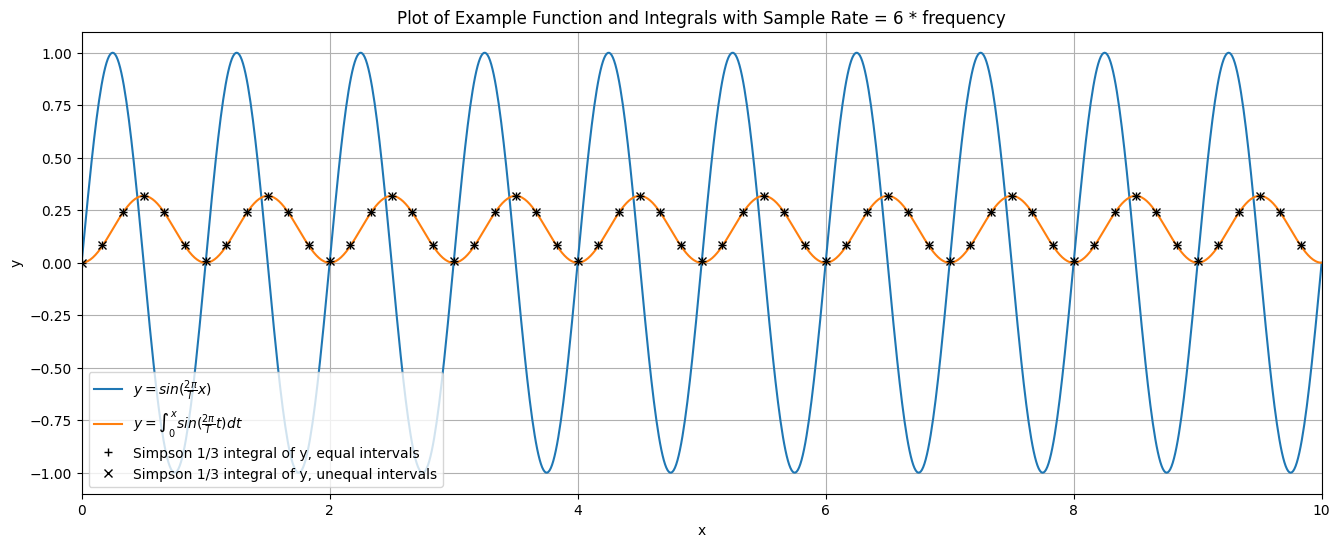

In [42]:
freq_y = 1
multiplier = 6
sample_freq_y = freq_y*multiplier
period_y = 1/freq_y
alpha = (2*np.pi/period_y)

t_max = 10
t = np.linspace(0, t_max, num=1000)
int_t = np.arange(0, t_max, 1/sample_freq_y)

def y(x):
    return np.sin(alpha*x)

def int_y(x):
    return (-np.cos(alpha*x) + 1)/alpha

simps_3_int_y = cumulative_simpson_equal(y(int_t), int_t, initial=0)
simps_3_uneven_int_y = cumulative_simpson_unequal(y(int_t), int_t, initial=0)

trapz_int_y = cumulative_trapezoid(y(int_t), int_t, initial=0)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(t, y(t), label=r"$y=sin(\frac{2\pi}{T} x)$")
ax.plot(t, int_y(t), label=r"$y=\int_0^x{sin(\frac{2\pi}{T} t) dt}$")
ax.plot(int_t, simps_3_int_y, 'k+', label="Simpson 1/3 integral of y, equal intervals")
ax.plot(int_t, simps_3_uneven_int_y, 'kx', label="Simpson 1/3 integral of y, unequal intervals")
# ax.plot(int_t, trapz_int_y, 'm.', label="Trapezoidal integral of y")
ax.set(xlabel="x", ylabel="y", xlim=(0, t_max), 
       title=f"Plot of Example Function and Integrals with Sample Rate = {multiplier} * frequency")
ax.legend(loc="lower left")
ax.grid()

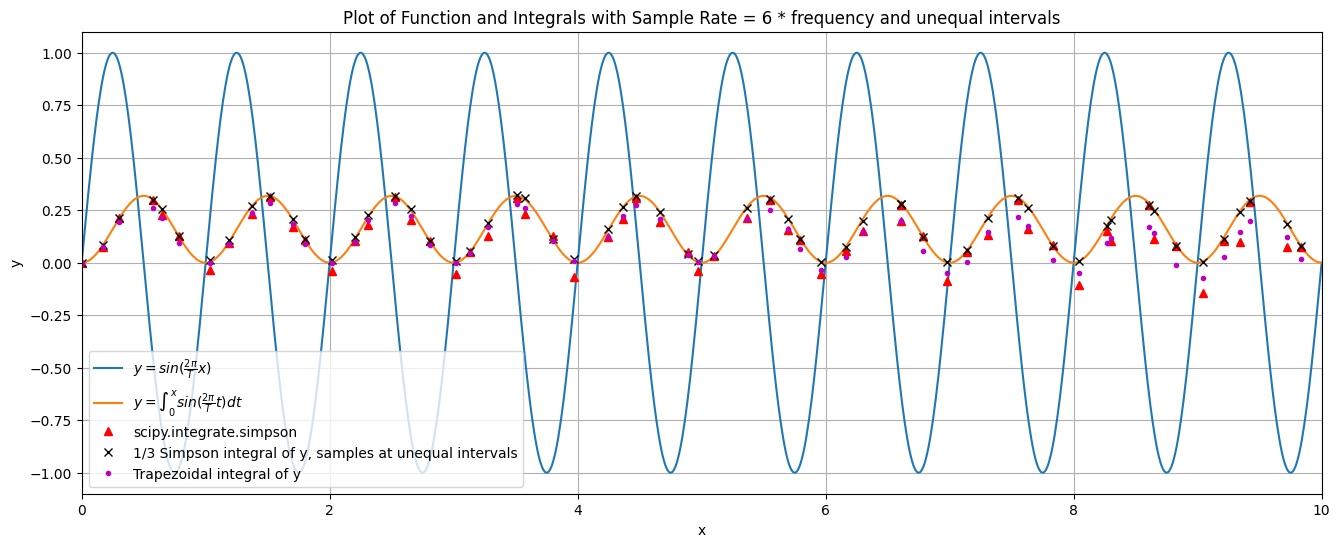

In [54]:
freq_y = 1
multiplier = 6
sample_freq_y = freq_y*multiplier
period_y = 1/freq_y
alpha = (2*np.pi/period_y)

t_max = 10
t = np.linspace(0, t_max, num=1000)
int_t = np.arange(0, t_max, 1/sample_freq_y)
int_t[1:-1] += np.random.normal(loc=0, scale=1, size=len(int_t)-2)*0.3*(1/sample_freq_y)

def y(x):
    return np.sin(alpha*x)

def int_y(x):
    return (-np.cos(alpha*x) + 1)/alpha

sp_simps_int_y = scipy_simps(y(int_t), int_t, initial=0)
simps_3_uneven_int_y = cumulative_simpson_unequal(y(int_t), int_t, initial=0)

trapz_int_y = cumulative_trapezoid(y(int_t), int_t, initial=0)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(t, y(t), label=r"$y=sin(\frac{2\pi}{T} x)$")
ax.plot(t, int_y(t), label=r"$y=\int_0^x{sin(\frac{2\pi}{T} t) dt}$")
ax.plot(int_t, sp_simps_int_y, 'r^', label="scipy.integrate.simpson")
ax.plot(int_t, simps_3_uneven_int_y, 'kx', label="1/3 Simpson integral of y, samples at unequal intervals")
ax.plot(int_t, trapz_int_y, 'm.', label="Trapezoidal integral of y")
ax.set(xlabel="x", ylabel="y", xlim=(0, t_max), 
       title=f"Plot of Function and Integrals with Sample Rate = {multiplier} * frequency and unequal intervals")
ax.legend(loc="lower left")
ax.grid()

The black points match the orange line --> this validates the cumulative_simpson implementation

## Quantify Errors

- Calculate the average error in the numerical integration over multiple sample rates (number of integration points).
- Plot the average error for different numerical integration methods over the range of sample rates.

In [44]:
from itertools import product

sample_rate = np.linspace(4, 50, num=100)
int_range = max(int_y(t)) - min(int_y(t))

def get_mean_error(cum_int_func, int_t, func=y, int_func=int_y):
    int_range = max(int_func(int_t)) - min(int_func(int_t))
    res = cum_int_func(func(int_t), int_t, initial=0)
    error = np.mean(np.abs(int_func(int_t) - res))/int_range
    return error

errors = {
    cumulative_simpson_equal: [],
    cumulative_simpson_unequal: [],
    cumulative_trapezoid: [],
    scipy_simps: [],
}
for sr, int_func in product(sample_rate, errors):
    int_t = np.arange(0, t_max, 1/sr)
    errors[int_func].append(get_mean_error(int_func, int_t))

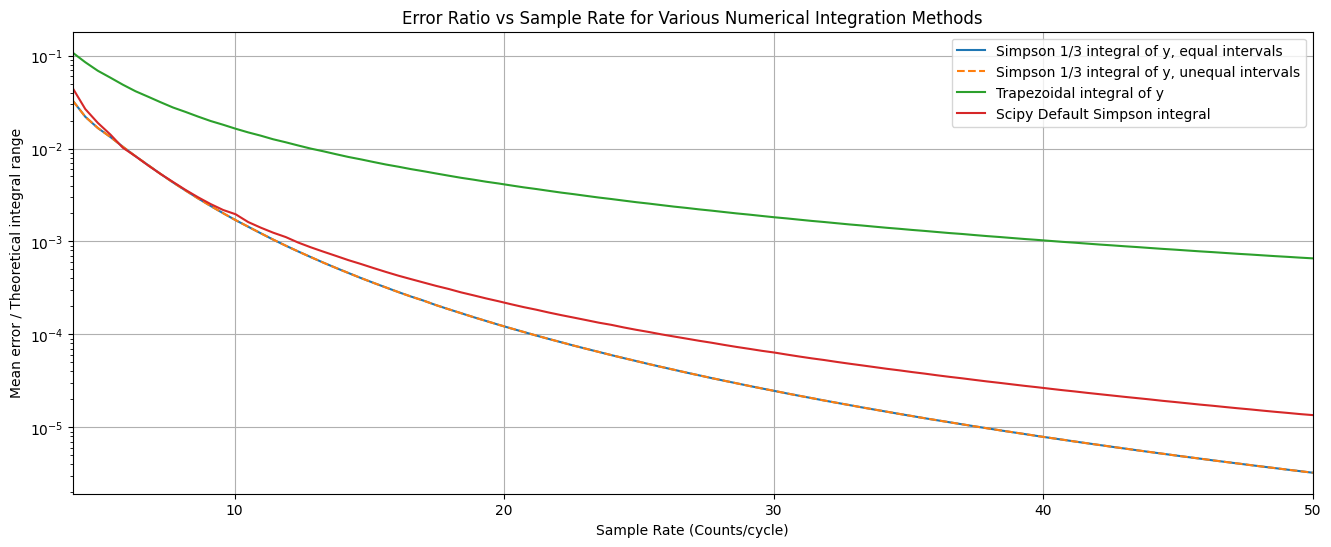

In [45]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.semilogy(sample_rate, errors[cumulative_simpson_equal], label="Simpson 1/3 integral of y, equal intervals")
ax.semilogy(sample_rate, errors[cumulative_simpson_unequal], '--', label="Simpson 1/3 integral of y, unequal intervals")
ax.semilogy(sample_rate, errors[cumulative_trapezoid], label="Trapezoidal integral of y")
ax.semilogy(sample_rate, errors[scipy_simps], label="Scipy Default Simpson integral")
ax.grid()
ax.set(xlim=(min(sample_rate), max(sample_rate)), xlabel="Sample Rate (Counts/cycle)", 
       ylabel="Mean error / Theoretical integral range", 
       title="Error Ratio vs Sample Rate for Various Numerical Integration Methods")
ax.legend()

In [46]:
sample_rate = np.linspace(4, 40, num=100)
int_range = max(int_y(t)) - min(int_y(t))
num_repeats = 5

def get_uneven_int_t(t_min, t_max, sr):
    int_t = np.arange(t_min, t_max, 1/sr)
    int_t[1:-1] += np.random.normal(loc=0, scale=1, size=len(int_t)-2)*0.3*(1/sr)
    return int_t

errors2 = {
    cumulative_simpson_unequal: [],
    cumulative_trapezoid: [],
    scipy_simps: [],
}
for sr in sample_rate:
    int_t_arr = [get_uneven_int_t(0, t_max, sr) for i in range(num_repeats)]
    for int_func in errors2:
        errors2[int_func].append(
            np.mean([get_mean_error(int_func, int_t) for int_t in int_t_arr])
        )

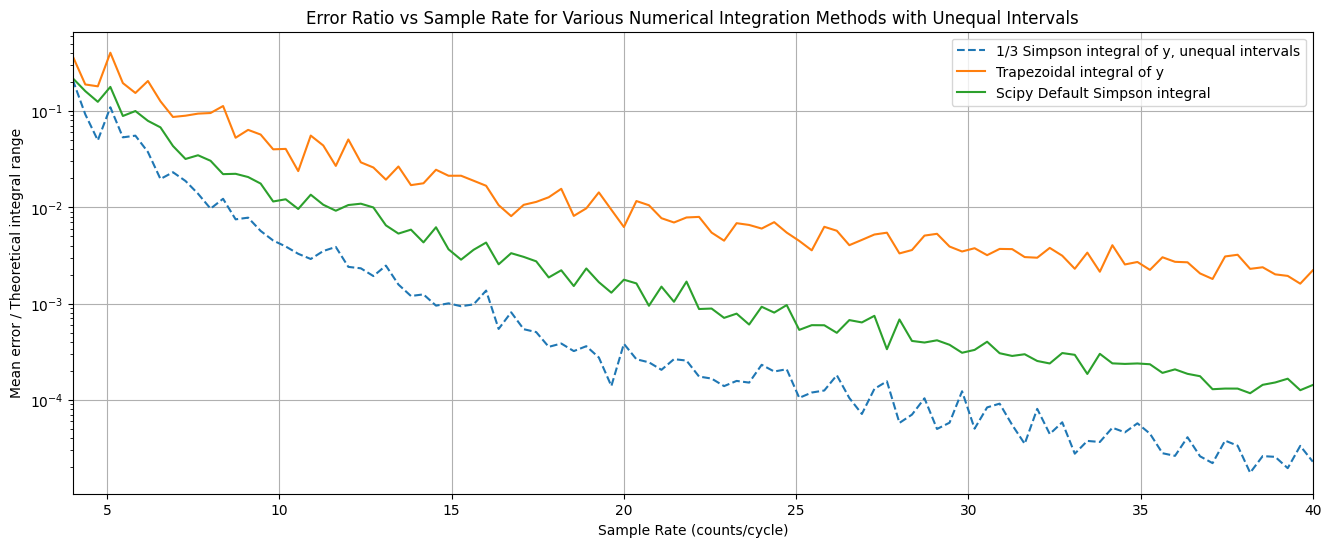

In [47]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.semilogy(sample_rate, errors2[cumulative_simpson_unequal], '--', label="1/3 Simpson integral of y, unequal intervals")
ax.semilogy(sample_rate, errors2[cumulative_trapezoid], label="Trapezoidal integral of y")
ax.semilogy(sample_rate, errors2[scipy_simps], label="Scipy Default Simpson integral")
ax.grid()
ax.set(xlim=(min(sample_rate), max(sample_rate)), xlabel="Sample Rate (counts/cycle)", 
       ylabel="Mean error / Theoretical integral range", 
       title="Error Ratio vs Sample Rate for Various Numerical Integration Methods with Unequal Intervals")
ax.legend()

### Accuracy Conclusions

Observations:
- The cumulative simpson's rule implementations are orders of magnitude more accurate than the Trapezoidal rule.
- The cumulative simpson function is similar or better in accuracy than the current scipy.integrate.simpson implementation for these examples.

## Quantify Timing

In [48]:
def time_func(func, max_time=2, num_runs=5, func_name=None):
    cts_per_run = []
    for run in range(num_runs):
        t_ct = t0 = perf_counter()
        ct = 0
        while t_ct - t0 < max_time/num_runs:
            func()
            ct += 1
            t_ct = perf_counter()
        cts_per_run.append(ct)
    best_ct = max(cts_per_run)
    loop_time = (max_time/num_runs)/best_ct
    if func_name is not None:
        print(func_name + ":")
    print(f"{best_ct} loops in {max_time/num_runs:.3f}s, best of {num_runs}: {loop_time:.3e}s per loop")
    return loop_time

In [49]:
methods = {
    "trapezoidal": cumulative_trapezoid,
    "simpson's 1/3 rule": cumulative_simpson_equal,
    "simpson's 1/3 rule with unequal intervals": cumulative_simpson_unequal,
    # "scipy.integrate.simpson": scipy_simps,
}
time_func(lambda: scipy_simps(y(int_t), int_t, initial=0), func_name="scipy.integrate.simpson")
timing = [time_func(lambda: func(y(int_t), int_t, initial=0), func_name=key) for key, func in methods.items()]

scipy.integrate.simpson:
10 loops in 0.400s, best of 5: 4.000e-02s per loop
trapezoidal:
12224 loops in 0.400s, best of 5: 3.272e-05s per loop
simpson's 1/3 rule:
6587 loops in 0.400s, best of 5: 6.073e-05s per loop
simpson's 1/3 rule with unequal intervals:
2766 loops in 0.400s, best of 5: 1.446e-04s per loop


In [52]:
num_pts = [100, 1000, 10000]
timing_results = {key: [] for key in methods.keys()}
for num, func_name in product(num_pts, timing_results):
    int_t = np.linspace(0, t_max, num=num)
    func = methods[func_name]
    timing_results[func_name].append(
        time_func(lambda: func(y(int_t), int_t, initial=0), func_name=func_name)
    )

trapezoidal:
16386 loops in 0.400s, best of 5: 2.441e-05s per loop
simpson's 1/3 rule:
10346 loops in 0.400s, best of 5: 3.866e-05s per loop
simpson's 1/3 rule with unequal intervals:
5287 loops in 0.400s, best of 5: 7.566e-05s per loop
trapezoidal:
9925 loops in 0.400s, best of 5: 4.030e-05s per loop
simpson's 1/3 rule:
6520 loops in 0.400s, best of 5: 6.135e-05s per loop
simpson's 1/3 rule with unequal intervals:
2486 loops in 0.400s, best of 5: 1.609e-04s per loop
trapezoidal:
2663 loops in 0.400s, best of 5: 1.502e-04s per loop
simpson's 1/3 rule:
1685 loops in 0.400s, best of 5: 2.374e-04s per loop
simpson's 1/3 rule with unequal intervals:
425 loops in 0.400s, best of 5: 9.412e-04s per loop


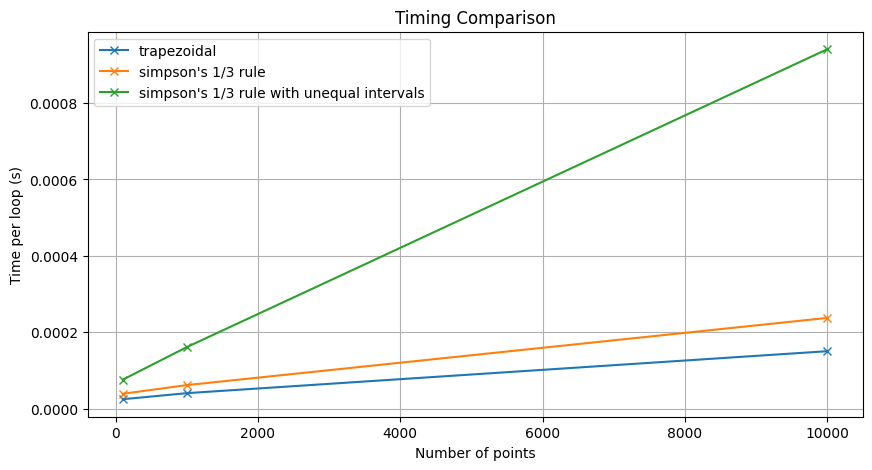

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(timing))
for key, value in timing_results.items():
    ax.plot(num_pts, value, 'x-', label=key)
ax.set(
    xlabel="Number of points",
    ylabel="Time per loop (s)",
    title="Timing Comparison",
)
ax.legend()
ax.grid()

Custom trapezoidal integration function is the most performant, but cumulative_simpson functions defined are also O(n) time and space.